<a href="https://colab.research.google.com/github/asubedi2001/FakeNewsDetection/blob/BiLSTM/BiLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install nltk --upgrade --force-reinstall

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.7/781.7 kB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.9/97.9 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 6.1 MB/s eta 0:00:00
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.66.6
    Uninstalling tqdm-4.66.6:
      Successfully uninstalled tqdm-4.66.6
  Attempting uninstall: regex
    Found existing installation: regex 2024.9.11
    Uninstalling regex-2024.9.11:
      Successfully uninstalled regex-2024.9.11
  Attempting uninstall: joblib
    Found existing installation: joblib 1.4.2
    Uninstalling joblib-1.4.2:
      Successfully uninstalled

Using device: cuda
The dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6591 entries, 0 to 6590
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   misconception_id  6591 non-null   int64 
 1   misconception     6591 non-null   object
 2   tweet_id          6591 non-null   int64 
 3   label             6591 non-null   object
dtypes: int64(2), object(2)
memory usage: 206.1+ KB

Data peek:
   misconception_id                                      misconception  \
0                 3             Coronavirus is genetically engineered.   
1                30  Blowing conch shells destroys coronavirus pote...   
2                57  Swans and dolphins swimming in Venice canals f...   
3                22                         Cocaine cures coronavirus.   
4                32  Observing janata curfew will result in the red...   
5                25  Holy communion cannot be the cause of the spre...   
6   

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1, Training loss: 0.8610
Validation Accuracy: 81.05%, Validation Loss 0.7345
Epoch 2, Training loss: 0.8024
Validation Accuracy: 84.08%, Validation Loss 0.7048
Epoch 3, Training loss: 0.7931
Validation Accuracy: 79.76%, Validation Loss 0.7470
Epoch 4, Training loss: 0.7891
Validation Accuracy: 79.83%, Validation Loss 0.7449
Epoch 5, Training loss: 0.7855
Validation Accuracy: 79.68%, Validation Loss 0.7447
Epoch 6, Training loss: 0.7820
Validation Accuracy: 79.83%, Validation Loss 0.7458
Epoch 7, Training loss: 0.7776
Validation Accuracy: 79.76%, Validation Loss 0.7453
Early stopping triggered


<ipython-input-5-44e1c0a4760d>:226: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth')) #load best weights


              precision    recall  f1-score   support

          na       0.98      0.85      0.91      1226
         pos       0.26      0.69      0.38        58
         neg       0.22      0.69      0.34        35

    accuracy                           0.84      1319
   macro avg       0.49      0.74      0.54      1319
weighted avg       0.93      0.84      0.88      1319

[[1045  105   76]
 [  11   40    7]
 [   5    6   24]]


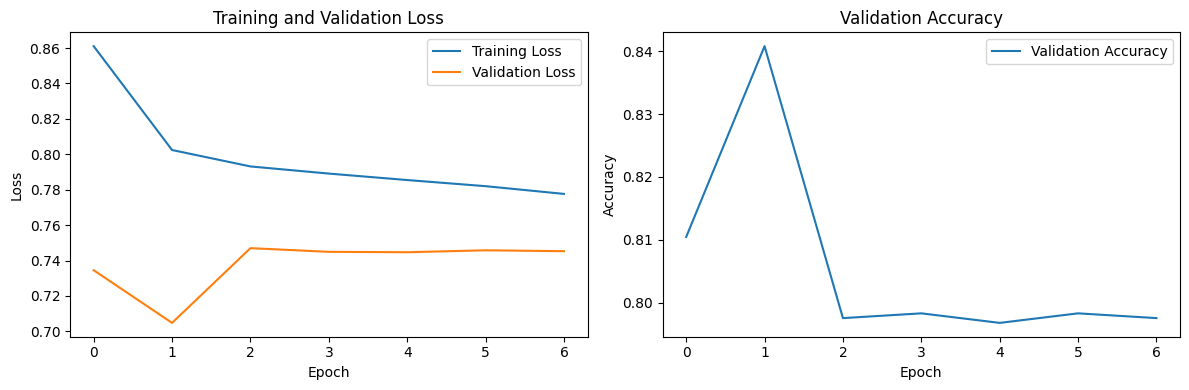

In [5]:
import numpy as np
import pandas as pd
import re
import nltk
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from nltk.corpus import stopwords
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from collections import Counter
from torch.nn.utils.rnn import pad_sequence

# Constants
PEEK = 10
EMBED_SIZE = 128
HIDDEN_SIZE = 256
NUM_LAYERS = 3
DROPOUT = 0.2
BATCH_SIZE = 32
LEARNING_RATE = 0.0001
EPOCHS = 30
RANDOM_STATE = 42

# Download NLTK resources
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)

# Check if CUDA (GPU) is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Helper function to print a peek of a list-like object
def present_list_like(name, list_like, peek=PEEK):
    print(f"{name} peek:")
    print('  ' + '\n  '.join([str(seq) for seq in list_like[0:peek]]) )

# Load the dataset
try:
  df = pd.read_csv('covid_lies.csv')  # Make sure 'covid_lies.csv' is in the correct path
except FileNotFoundError:
    print("Error: 'covid_lies.csv' not found. Please ensure it is in the same directory or provide the correct path.")
    exit()
print("The dataset:")
df.info()
print("\nData peek:")
print(df.head(PEEK))
print()

# Separate out text data and labels
input_text = df['misconception'].to_numpy()
input_labels = df['label'].to_numpy()
print("Unique labels:", np.unique(input_labels))


# Text preprocessing function (precompiled regex)
RE_SPACE = re.compile(r'\s+')
RE_URL = re.compile(r'http\S+')

def preprocess_text(text)->str:
    text = text.lower()
    valid_asciis = {9, *range(32, 127)}
    text = ''.join(filter(lambda x: ord(x) in valid_asciis, text))
    text = RE_SPACE.sub(' ', text)
    text = RE_URL.sub('', text)
    stop_words = set(stopwords.words('english'))
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

# Preprocess text
for i in range(len(input_text)):
    input_text[i] = preprocess_text(input_text[i])

# Tokenize text
input_tokens = [nltk.word_tokenize(text) for text in input_text]

# Further split tokens based on non-alphanumeric characters
final_tokens = []
total_tokens = 0
for token_set in input_tokens:
    final_tkn_set = []
    for tk in token_set:
        sub_tkns = [c for c in re.split(r"(\W+)", tk) if c]
        total_tokens += len(sub_tkns)
        final_tkn_set += sub_tkns
    final_tokens.append(final_tkn_set)
present_list_like(f"Tokenized sentences({len(final_tokens)} sentences, {total_tokens} tokens)", final_tokens)

# Create vocabulary
flat_tokens = [word for token_set in final_tokens for word in token_set]
frequencies = Counter(flat_tokens)
token_to_idx = {word: idx+1 for idx, (word, _) in enumerate(frequencies.most_common())}
vocab_size = len(token_to_idx)
print(vocab_size, "unique tokens")
present_list_like("Unique tokens", list(token_to_idx.keys()))

# Convert tokens to indices
input_indices = [[token_to_idx[token] for token in token_set] for token_set in final_tokens]

# Pad sequences
input_indices_padded = [torch.tensor(seq, dtype=torch.long) for seq in input_indices]
input_indices_padded = pad_sequence(input_indices_padded, batch_first=True, padding_value=0).to(device)

present_list_like(f"\nFinal Index Sets({len(input_indices_padded)} index sets)", input_indices_padded)

# Print label distribution
print(Counter(input_labels))

# Convert labels to numerical representations before splitting
labels_numeric, unique_labels = pd.factorize(input_labels)

# Split data into training and validation sets BEFORE SMOTE
x_train, x_val, y_train, y_val = train_test_split(input_indices_padded, labels_numeric, test_size=0.2, random_state=RANDOM_STATE)

# Handle class imbalance ONLY on the training data using SMOTE
# IMPORTANT FIX: Move to CPU and numpy after the train/val split
x_train_cpu = x_train.cpu().numpy()
y_train_cpu = y_train
smote = SMOTE(random_state=RANDOM_STATE)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train_cpu, y_train_cpu)
x_train_resampled = torch.tensor(x_train_resampled, dtype=torch.long).to(device)
y_train_resampled = torch.tensor(y_train_resampled, dtype=torch.long).to(device)


# Convert y_val to a PyTorch tensor before creating the TensorDataset
# Create TensorDatasets
train_dataset = TensorDataset(x_train_resampled, y_train_resampled)
val_dataset = TensorDataset(x_val, torch.tensor(y_val, dtype=torch.long).to(device))  # Convert y_val to tensor

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Define the BiLSTM model with dropout
class MisInformationDetectionBiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, dropout=0.2, embed_size=128):  # Add embed_size here
        super(MisInformationDetectionBiLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size + 1, embed_size, padding_idx=0)
        self.dropout1 = nn.Dropout(dropout)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout, bidirectional=True)
        self.dropout2 = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size * 2, output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        embedded = self.embedding(x)
        embedded = self.dropout1(embedded)
        lstm_out, (hidden, _) = self.lstm(embedded)
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        hidden = self.dropout2(hidden)
        output = self.fc(hidden)
        return self.softmax(output)

# Instantiate the BiLSTM model
model = MisInformationDetectionBiLSTM(EMBED_SIZE, HIDDEN_SIZE, len(unique_labels), NUM_LAYERS, DROPOUT).to(device)

# Loss function and optimizer
counter_data = Counter(input_labels)
class_counts = list(counter_data.values())
class_weights = 1. / torch.tensor(class_counts, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=torch.tensor([1.5, 1.2, 1.0]).to(device))
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

# Model training function with early stopping
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=10, patience=5):
    best_val_loss = float('inf')
    epochs_no_improve = 0
    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        train_loss_avg = total_loss/len(train_loader)
        train_losses.append(train_loss_avg)
        print(f'Epoch {epoch+1}, Training loss: {train_loss_avg:.4f}')

        model.eval()
        correct, total = 0, 0
        val_loss = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_loss_avg = val_loss/len(val_loader)
        val_losses.append(val_loss_avg)
        val_accuracy = correct / total
        val_accuracies.append(val_accuracy)
        print(f"Validation Accuracy: {val_accuracy*100:.2f}%, Validation Loss {val_loss_avg:.4f}")
        scheduler.step(val_loss_avg) #Step scheduler based on validation loss

        #Early Stopping
        if val_loss_avg < best_val_loss:
            best_val_loss = val_loss_avg
            epochs_no_improve = 0
            torch.save(model.state_dict(), 'best_model.pth') #save best performing model
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print("Early stopping triggered")
                break

    return train_losses, val_losses, val_accuracies #Return for logging

# Train the model
train_losses, val_losses, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=EPOCHS)

# Model evaluation function
def evaluate_model(model, val_loader):
    model.load_state_dict(torch.load('best_model.pth')) #load best weights
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.tolist())
            y_pred.extend(predicted.tolist())
    print(classification_report(y_true, y_pred, target_names=unique_labels))
    print(confusion_matrix(y_true, y_pred))

# Evaluate the model
evaluate_model(model, val_loader)

#plot graphs
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

In [7]:
#DO NOT USE THIS VERSION BALANCES THE WHOLE DATASET
import numpy as np
import pandas as pd
import re
import nltk
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from nltk.corpus import stopwords
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from collections import Counter

# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
# Determine if CUDA (GPU) is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


# Helper function to print a peek of a list-like object
peek = 10
def present_list_like(name, list_like, peek=peek):
    print(f"{name} peek:")
    print('  ' + '\n  '.join([str(seq) for seq in list_like[0:peek]]))


# Load the dataset
df = pd.read_csv('covid_lies.csv')  # Make sure 'covid_lies.csv' is in the correct path
print("The dataset:")
df.info()
print("\nData peek:")
print(df.head(peek))
print()

# Separate out text data and labels
input_text = df['misconception'].to_numpy()
input_label = df['label'].to_numpy()
print("Unique labels:", np.unique(input_label))

# Text preprocessing function
def preprocess_text(text)->str:
    # Letter-level cleaning
    text = text.lower()
    valid_asciis = {9, *range(32, 127)}
    text = ''.join(filter(lambda x: ord(x) in valid_asciis, text))

    # Word/sequence-level cleaning
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'http\S+', '', text)
    stop_words = set(stopwords.words('english'))
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

# Preprocess text
for i in range(len(input_text)):
    input_text[i] = preprocess_text(input_text[i])

# Tokenize text using nltk.word_tokenize
input_tokens = [nltk.word_tokenize(text) for text in input_text]


# Further split tokens based on non-alphanumeric characters
final_tokens = []
total_tokens = 0
for token_set in input_tokens:
    final_tkn_set = []
    for tk in token_set:
        sub_tkns = [c for c in re.split(r"(\W+)", tk) if c]
        total_tokens += len(sub_tkns)
        final_tkn_set += sub_tkns
    final_tokens.append(final_tkn_set)
present_list_like(f"Tokenized sentences({len(final_tokens)} sentences, {total_tokens} tokens)", final_tokens)

# Embed the tokens
# Map each token to its frequency in the dataset
flat_tokens = [word for token_set in final_tokens for word in token_set]
frequencies = Counter(flat_tokens)
token_to_idx = {word: idx+1 for idx, (word, _) in enumerate(frequencies.most_common())}
vocab_size = len(token_to_idx)
print(vocab_size, "unique tokens")
present_list_like("Unique tokens", list(token_to_idx.keys()))

# Convert tokens to numerical indices
freq_indexed = [[token_to_idx[token] for token in token_set] for token_set in final_tokens]

# Pad sequences to make them of the same length
forced_idx_set_size = max(len(idxs) for idxs in freq_indexed)
freq_indexed = [
    idxs[:forced_idx_set_size] + [0]*(forced_idx_set_size - len(idxs))
    for idxs in freq_indexed
]
present_list_like(f"\nFinal Index Sets(Set_Size = {forced_idx_set_size}, {len(freq_indexed)} index sets)", freq_indexed)

# Print label counts
print(Counter(input_label))

# Handle class imbalance using SMOTE
labels_numeric, unique_labels = pd.factorize(input_label)
x = np.array(freq_indexed)
y = np.array(labels_numeric)

smote = SMOTE(random_state=42)
x_resampled, y_resampled = smote.fit_resample(x, y)

# Split data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_resampled, y_resampled, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors and move to the appropriate device
x_train_tensor = torch.tensor(x_train, dtype=torch.long).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
x_val_tensor = torch.tensor(x_val, dtype=torch.long).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.long).to(device)

# Create TensorDatasets
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Define the BiLSTM model
class MisInformationDetectionBiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, dropout=0.2):
        super(MisInformationDetectionBiLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size + 1, embed_size, padding_idx=0)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, (hidden, _) = self.lstm(embedded)
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        output = self.fc(hidden)
        return self.softmax(output)

# Model parameters
vocab_size = len(token_to_idx)
embed_size = 128
input_size = embed_size
hidden_size = 256
output_size = len(unique_labels)
num_layers = 3
dropout = 0.2

# Instantiate the BiLSTM model and move to the device
model = MisInformationDetectionBiLSTM(input_size, hidden_size, output_size, num_layers, dropout).to(device)


# Loss function and optimizer
counter_data = Counter(input_label)
class_counts = list(counter_data.values())
class_weights = 1. / torch.tensor(class_counts, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=torch.tensor([1.5, 1.2, 1.0]).to(device))
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)


# Model training function
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f'Epoch {epoch+1}, Training loss: {total_loss/len(train_loader):.4f}')

        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        print(f"Validation Accuracy: {correct/total*100:.2f}%")

# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, epochs=30)

# Model evaluation function
def evaluate_model(model, val_loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.tolist())
            y_pred.extend(predicted.tolist())

    print(classification_report(y_true, y_pred, target_names=unique_labels))
    print(confusion_matrix(y_true, y_pred))

# Evaluate the model
evaluate_model(model, val_loader)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Using device: cuda
The dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6591 entries, 0 to 6590
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   misconception_id  6591 non-null   int64 
 1   misconception     6591 non-null   object
 2   tweet_id          6591 non-null   int64 
 3   label             6591 non-null   object
dtypes: int64(2), object(2)
memory usage: 206.1+ KB

Data peek:
   misconception_id                                      misconception  \
0                 3             Coronavirus is genetically engineered.   
1                30  Blowing conch shells destroys coronavirus pote...   
2                57  Swans and dolphins swimming in Venice canals f...   
3                22                         Cocaine cures coronavirus.   
4                32  Observing janata curfew will result in the red...   
5                25  Holy communion cannot be the cause of the spre...   
6   